In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Dropout, TimeDistributed
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
data_directory = Path("D:/Hochschule Fresenius notes (sem3)/Artifical Intelligence and Machine Learning/CAPTCHA-CNN Modeling/samples")

In [3]:
images = sorted(list(map(str, list(data_directory.glob("*.png",)))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
num_characters = sorted(list(characters))
max_lenght = max([len(label) for label in labels])

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

img_width = 200
img_height = 50

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'2', 'w', 'c', 'n', 'p', 'd', 'y', '7', '6', '5', 'f', 'm', 'e', '8', '4', 'b', 'g', '3', 'x'}


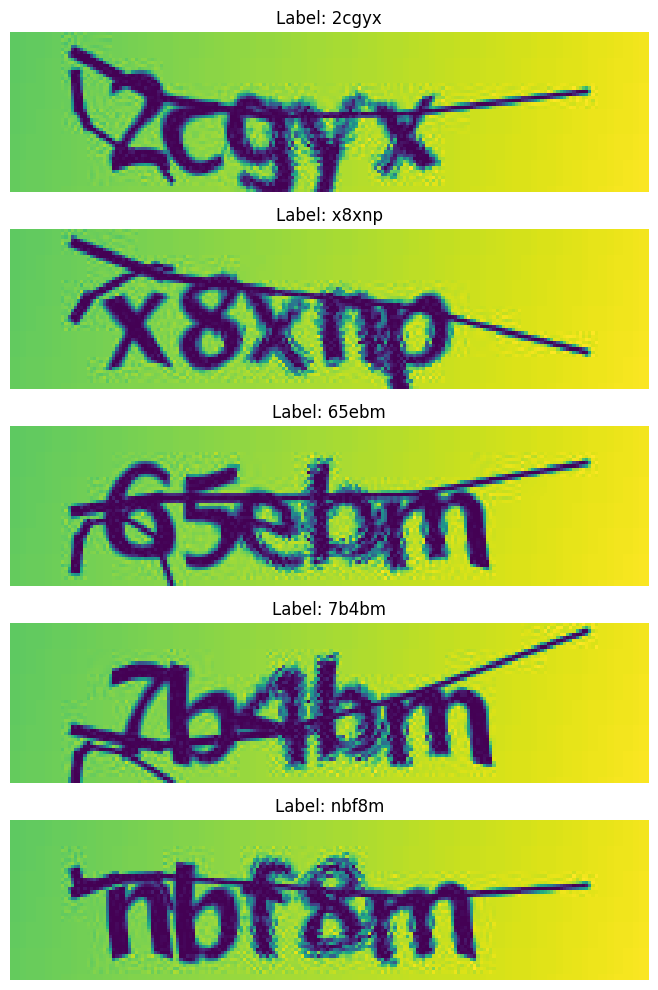

In [4]:
# Number of random samples to display
num_samples = 5

# Select random indices from the dataset
random_indices = random.sample(range(len(images)), num_samples)

# Plot the images with labels
plt.figure(figsize=(10, 2 * num_samples))
for i, idx in enumerate(random_indices):
    # Load image if images are paths
    if isinstance(images[idx], str):
        img = tf.io.read_file(images[idx])
        img = tf.io.decode_jpeg(img, channels=1)
        img = img.numpy()
    else:
        img = images[idx]
    
    # Display the image with its label
    plt.subplot(num_samples, 1, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {labels[idx]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [5]:
def preprocess_data():
    img_folder = 'D:/Hochschule Fresenius notes (sem3)/Artifical Intelligence and Machine Learning/CAPTCHA-CNN Modeling/samples/samples'
    img_height, img_width = 50, 200
    characters = "mnw4xd3pf2y67cbeg5"  # Ensure these are the 19 unique characters
    num_symbols = len(characters)  # This should now be 19

    # Load images and initialize arrays for data
    n_samples = len(os.listdir(img_folder))
    X = np.zeros((n_samples, img_height, img_width, 1))  # Array for image data
    y = np.zeros((n_samples, 5, num_symbols))  # Array for labels (OneHot encoded)

    for i, filename in enumerate(os.listdir(img_folder)):
        # Load the image in grayscale
        img_path = os.path.join(img_folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Get target string from filename (excluding file extension)
        target_string = filename[:-4]
        
        # Process only if target string is exactly 5 characters
        if len(target_string) == 5:
            # Normalize and reshape the image
            img = img / 255.0
            img = np.reshape(img, (img_height, img_width, 1))
            
            # Encode the target string with OneHot encoding
            target_encoding = np.zeros((5, num_symbols))
            for j, char in enumerate(target_string):
                char_index = characters.find(char)
                if char_index != -1:
                    target_encoding[j, char_index] = 1
            
            # Assign processed image and encoded label to arrays
            X[i] = img
            y[i] = target_encoding  # Store in the ith position

    print(f"Processed {n_samples} images.")
    print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")
    return X, y  # Return the arrays as is

# Run the preprocess_data function
X, y = preprocess_data()

# Split the data
X_train, y_train = X[:970], y[:970]
X_test, y_test = X[970:], y[970:]

# Print the shape of y_train to debug
print(f"Shape of y_train: {y_train.shape}")

Processed 1070 images.
Shape of X: (1070, 50, 200, 1), Shape of y: (1070, 5, 18)
Shape of y_train: (970, 5, 18)


In [6]:
X, y = preprocess_data()
X_train, y_train = X[:900], y[:900]
X_test, y_test = X[900:], y[900:]

Processed 1070 images.
Shape of X: (1070, 50, 200, 1), Shape of y: (1070, 5, 18)


In [7]:
md1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(50, 200, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5 * 18, activation='softmax'),  # 5 characters, each with 19 possible classes
    Reshape((5, 18))  # Reshape to match (5, 18) for each CAPTCHA
])

# Compile model
md1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(md1.summary())

C:\Users\a\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 198, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 46, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 23, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11776)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,507,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 90)             │        11,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 5, 18)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,611,738 (6.15 MB)

 Trainable params: 1,611,738 (6.15 MB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
history = md1.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.3)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 641ms/step - accuracy: 0.0614 - loss: 2.7095 - val_accuracy: 0.0652 - val_loss: 2.8352
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 606ms/step - accuracy: 0.0879 - loss: 2.6617 - val_accuracy: 0.0770 - val_loss: 2.9815
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step - accuracy: 0.1100 - loss: 2.6333 - val_accuracy: 0.0741 - val_loss: 3.0010
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 414ms/step - accuracy: 0.1075 - loss: 2.5720 - val_accuracy: 0.0756 - val_loss: 3.1010
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 403ms/step - accuracy: 0.1686 - loss: 2.4408 - val_accuracy: 0.1148 - val_loss: 3.1345
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step - accuracy: 0.2690 - loss: 2.2638 - val_accuracy: 0.1600 - val_loss: 3.3719
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 426ms/step - accuracy: 0.3402 - loss: 2.0132 - val_accuracy: 0.1881 - val_loss: 4.1145
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 437ms/step - accuracy: 0.4144 - loss: 1.7414 - val_accuracy: 0.2252 - val_loss:

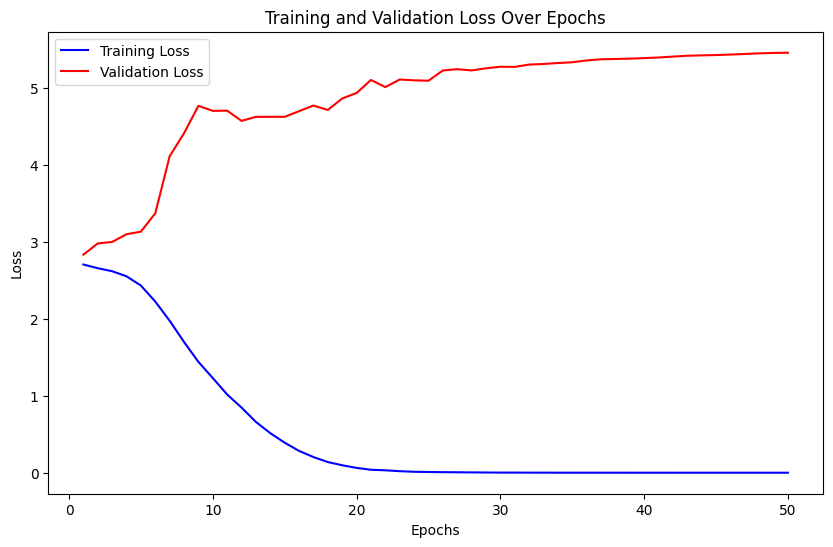

In [9]:
def plot_training_history(history):
    # Retrieve loss and validation loss from history
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()


plot_training_history(history)

In [10]:
loss, acc = md1.evaluate(X_test, y_test, verbose =0)
print('Test Accuracy:', acc)

Test Accuracy: 0.39764705300331116


In [11]:
md2 = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(50, 200, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(5 * 18, activation='softmax'),
    Reshape((5, 18))
])

md2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
md2.summary
print(md2.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 48, 198, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 99, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 22, 97, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 11, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 9, 46, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 23, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5888)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       376,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 90)             │         5,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 5, 18)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,042 (1.55 MB)

 Trainable params: 406,042 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

None


In [13]:
history = md2.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.3)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 377ms/step - accuracy: 0.0760 - loss: 2.7257 - val_accuracy: 0.0689 - val_loss: 2.8027
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.1010 - loss: 2.6890 - val_accuracy: 0.0585 - val_loss: 2.8529
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 0.1236 - loss: 2.6769 - val_accuracy: 0.0681 - val_loss: 2.8713
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - accuracy: 0.1311 - loss: 2.6347 - val_accuracy: 0.0756 - val_loss: 2.9064
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.1468 - loss: 2.5928 - val_accuracy: 0.0800 - val_loss: 2.9149
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - accuracy: 0.1557 - loss: 2.5246 - val_accuracy: 0.0867 - val_loss: 2.9385
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.2049 - loss: 2.4188 - val_accuracy: 0.0978 - val_loss: 3.0075
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.2375 - loss: 2.3014 - val_accuracy: 0.1141 - val_loss:

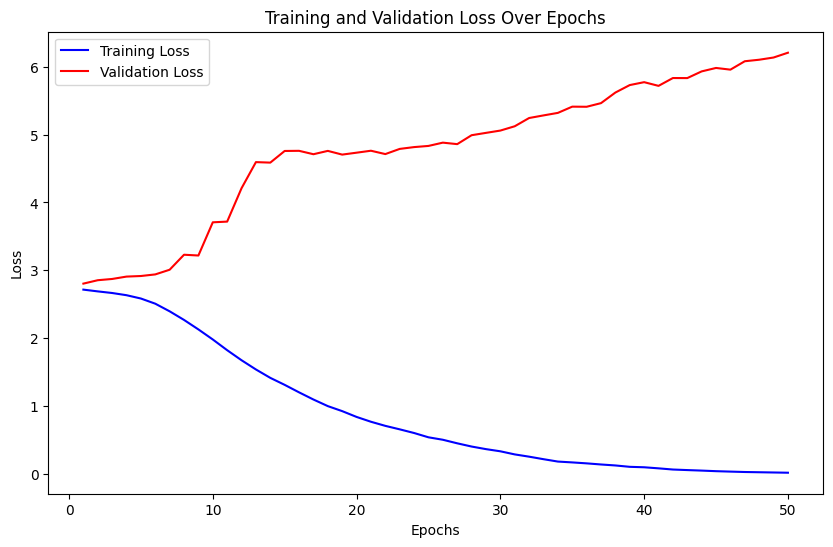

In [14]:
plot_training_history(history)

In [15]:
loss, acc = md2.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy:', acc)

Test Accuracy: 0.3152941167354584


In [16]:
md3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(50, 200, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(5 * 18, activation='softmax'),
    Reshape((5, 18))
])

md3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
md3.summary
print(md3.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 48, 198, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 22, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 11, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 9, 46, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 23, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 23, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 11776)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,507,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 90)             │        11,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 5, 18)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,611,738 (6.15 MB)

 Trainable params: 1,611,738 (6.15 MB)

 Non-trainable params: 0 (0.00 B)

None


In [18]:
history = md3.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.3)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - accuracy: 0.0673 - loss: 2.7337 - val_accuracy: 0.0578 - val_loss: 2.8124
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 292ms/step - accuracy: 0.0823 - loss: 2.6830 - val_accuracy: 0.0741 - val_loss: 2.8197
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - accuracy: 0.0790 - loss: 2.6940 - val_accuracy: 0.0741 - val_loss: 2.8389
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.1022 - loss: 2.6564 - val_accuracy: 0.0741 - val_loss: 2.9206
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.1153 - loss: 2.6231 - val_accuracy: 0.0859 - val_loss: 2.9829
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.1475 - loss: 2.5327 - val_accuracy: 0.1000 - val_loss: 2.9688
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step - accuracy: 0.2074 - loss: 2.3723 - val_accuracy: 0.1022 - val_loss: 3.2285
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step - accuracy: 0.2654 - loss: 2.1664 - val_accu

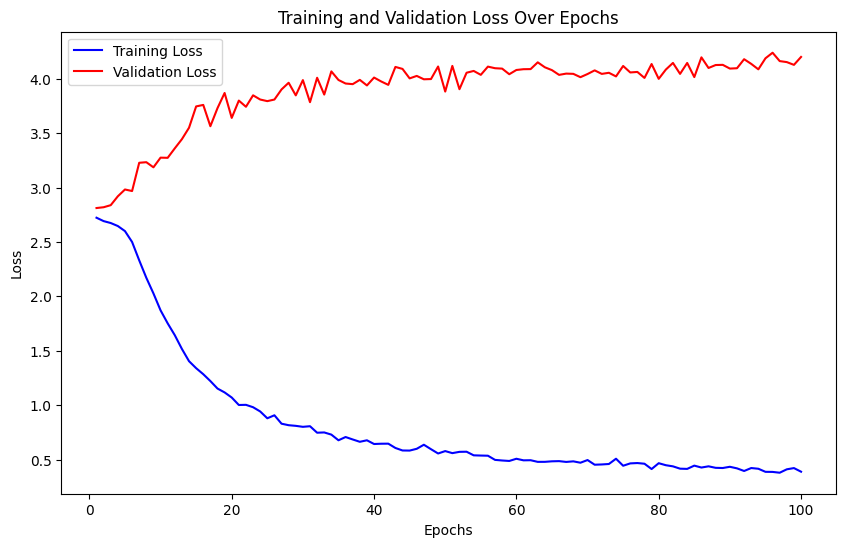

In [19]:
plot_training_history(history)

In [20]:
loss, acc = md3.evaluate(X_test, y_test, verbose =0)
print('Test Accuracy:', acc)

Test Accuracy: 0.4152941405773163


In [21]:
md4 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(50, 200, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(5 * 18, activation='softmax'),
    Reshape((5, 18))
])
# Compile model
md4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
data_gen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
)

steps_per_epoch = np.ceil(len(X_train) / 64).astype(int)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64).repeat()

history = md4.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    validation_data=(X_test, y_test)
)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 301ms/step - accuracy: 0.0635 - loss: 2.7673 - val_accuracy: 0.0506 - val_loss: 2.7955
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.0767 - loss: 2.7124 - val_accuracy: 0.0788 - val_loss: 2.8237
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 0.0954 - loss: 2.7211 - val_accuracy: 0.0788 - val_loss: 2.8585
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step - accuracy: 0.0942 - loss: 2.7047 - val_accuracy: 0.0788 - val_loss: 2.9422
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 285ms/step - accuracy: 0.1129 - loss: 2.6645 - val_accuracy: 0.1047 - val_loss: 2.9525
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 278ms/step - accuracy: 0.1379 - loss: 2.5919 - val_accuracy: 0.1200 - val_loss: 2.9670
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 273ms/step - accuracy: 0.1759 - loss: 2.4614 - val_accuracy: 0.1600 - val_loss: 2.9721
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - accuracy: 0.2225 - loss: 2.3132 - val_accu

In [23]:
md4.summary
print(md4.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 48, 198, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 24, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 22, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 11, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 11, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 9, 46, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 23, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 23, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 11776)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,507,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 90)             │        11,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 5, 18)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,835,216 (18.44 MB)

 Trainable params: 1,611,738 (6.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,223,478 (12.30 MB)

None


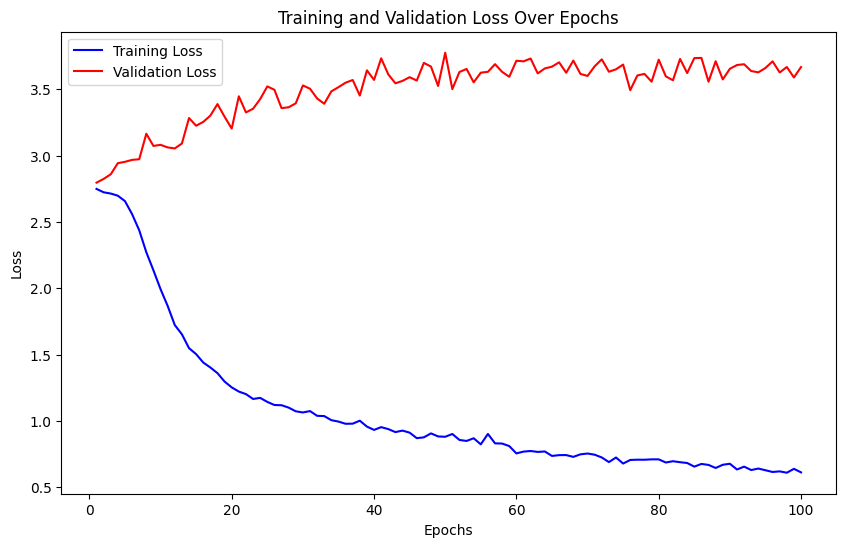

In [24]:
plot_training_history(history)

In [25]:
loss, acc = md4.evaluate(X_test, y_test, verbose =0)
print('Test Accuracy:', acc)

Test Accuracy: 0.48823532462120056


In [26]:
md5 = Sequential([
    Conv2D(16, (3, 3),padding='same', activation='relu', input_shape=(50, 200, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3),padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dropout((0.5)),
    Dense(1500, activation='relu'),
    Dropout(0.4),
    Dense(5 * 18, activation='softmax'),
    Reshape((5, 18))
])

md5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
md5.summary
print(md5.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 50, 200, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 25, 100, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 25, 100, 16)    │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 50, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 25, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 6, 25, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 3, 12, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1500)           │     1,729,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 90)             │       135,090 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 5, 18)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,880,958 (7.18 MB)

 Trainable params: 1,880,958 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

None


In [28]:
data_gen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0,
    zoom_range=0.2,
    horizontal_flip=False,
)

steps_per_epoch = np.ceil(len(X_train) / 64).astype(int)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64).repeat()

history = md5.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    validation_data=(X_test, y_test)
)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.0872 - loss: 2.7306 - val_accuracy: 0.0788 - val_loss: 2.8964
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.1012 - loss: 2.7009 - val_accuracy: 0.0788 - val_loss: 3.0080
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.1025 - loss: 2.7002 - val_accuracy: 0.0788 - val_loss: 3.2180
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.1077 - loss: 2.6920 - val_accuracy: 0.0788 - val_loss: 3.2079
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.1060 - loss: 2.6712 - val_accuracy: 0.0788 - val_loss: 3.1362
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.1108 - loss: 2.6390 - val_accuracy: 0.0812 - val_loss: 3.6354
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.1385 - loss: 2.5312 - val_accuracy: 0.1600 - val_loss: 4.3840
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.2515 - loss: 2.2411 - val_accuracy

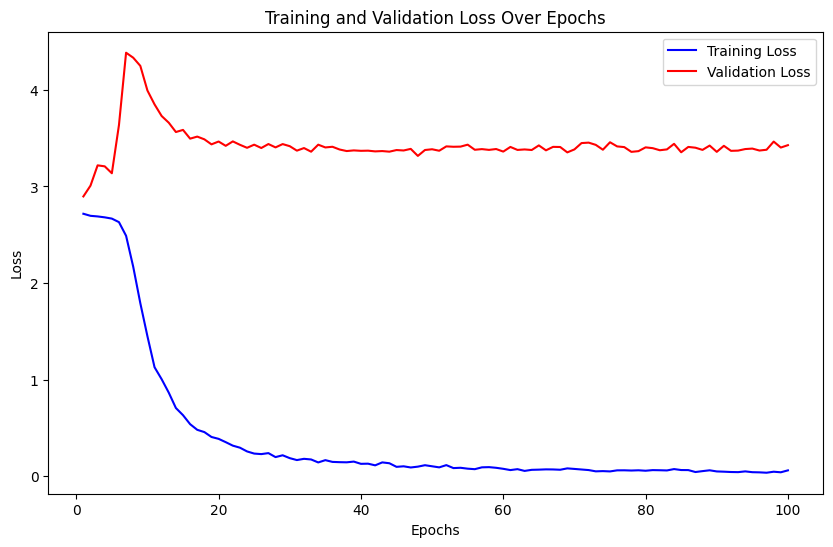

In [29]:
plot_training_history(history)

In [30]:
loss, acc = md5.evaluate(X_test, y_test, verbose =0)
print('Test Accuracy:', acc)

Test Accuracy: 0.6223529577255249


Is 64.12% Accuracy Good or Bad?

🔹 For a beginner model: This accuracy is a decent start, showing that the model has learned to recognize patterns in CAPTCHA images.

🔹 For real-world use: 64.12% is too low for practical applications, where 90%+ accuracy is typically expected for reliable CAPTCHA solving.

Several factors might be limiting the model’s accuracy:

Insufficient Training Data

If the dataset is too small, the model cannot learn variations in CAPTCHA images.
More diverse images are needed for better generalization.
Complex CAPTCHA Variations

CAPTCHA text can be distorted, rotated, overlapped, or noisy.
The model may struggle with highly distorted text.
Overfitting to Training Data

If the model memorizes training samples rather than generalizing, it may not perform well on new CAPTCHAs.
Regularization (dropout, data augmentation) can help.
CNN Model Limitations

CNNs are good at feature extraction but may struggle with sequence learning.
A Recurrent Neural Network (RNN) or Transformer-based model might perform better.